In [86]:
import torch
from torchvision import transforms
from diffusers import DDIMScheduler
from tqdm import tqdm
from condition_dataset import ConditionalFramesDataset
from model import UNet

device = "cuda" if torch.cuda.is_available() else "cpu"

batch_size = 64
dataset = ConditionalFramesDataset("frames_dataset_skip", 3)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
model = UNet().to(device)
diffusion_steps = 500
model.load_state_dict(torch.load('unet_model.pth'))
model.eval()

UNet(
  (image_proj): Conv2d(6, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_emb): TimeEmbedding(
    (lin1): Linear(in_features=32, out_features=128, bias=True)
    (act): Swish()
    (lin2): Linear(in_features=128, out_features=128, bias=True)
  )
  (encoder_hid_proj): Linear(in_features=4, out_features=128, bias=True)
  (text_emb): TextTimeEmbedding(
    (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (pool): AttentionPooling(
      (k_proj): Linear(in_features=128, out_features=128, bias=True)
      (q_proj): Linear(in_features=128, out_features=128, bias=True)
      (v_proj): Linear(in_features=128, out_features=128, bias=True)
    )
    (proj): Linear(in_features=128, out_features=128, bias=True)
    (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  )
  (down): ModuleList(
    (0): DownBlock(
      (res): ResidualBlock(
        (norm1): GroupNorm(16, 32, eps=1e-05, affine=True)
        (act1): Swish()
        (conv1): Conv2d(32,

In [92]:
# DDIM sampling
x = torch.randn(batch_size, 3, 120, 160, device=device)
w = 2.0

prev_frame, actions, target_frame = next(iter(dataloader))
prev_frame = prev_frame.repeat(2, 1, 1, 1).to(device)
actions = actions.repeat(2, 1, 1).to(device)

mask = torch.ones((actions.size(0),), device=device)
mask[batch_size:] = 0
image_mask = mask.view(-1, 1, 1, 1)
text_mask = mask.view(-1, 1, 1)  # [batch, sequence, vocab]

scheduler = DDIMScheduler(num_train_timesteps=diffusion_steps, clip_sample=True, set_alpha_to_one=False)
scheduler.set_timesteps(50)


for t in tqdm(scheduler.timesteps):
    x = x.repeat(2, 1, 1, 1)

    with torch.no_grad():
        noise_pred = model(
            torch.cat((x, image_mask * prev_frame), dim=1),
            t.repeat(actions.size(0)).to(device),
            text_mask * actions,
        )

    noise_pred_text, noise_pred_uncond = noise_pred.chunk(2)
    noise_pred = noise_pred_text + w * (noise_pred_text - noise_pred_uncond)

    x = scheduler.step(noise_pred, t, x[:batch_size]).prev_sample


invTrans = transforms.Compose(
    [
        transforms.Normalize(mean=[0.0, 0.0, 0.0], std=[1 / 0.5, 1 / 0.5, 1 / 0.5]),
        transforms.Normalize(mean=[-0.5, -0.5, -0.5], std=[1.0, 1.0, 1.0]),
        transforms.ToPILImage(),
    ]
)

# pil_images = list(map(lambda x: invTrans(x), x))
# for idx, i in enumerate(pil_images):
#     i.save(f"generations/{idx}.png")

# cond_images = list(map(lambda x: invTrans(x), prev_frame[:batch_size]))
# for idx, i in enumerate(cond_images):
#     i.save(f"conditions/{idx}.png")

# cond_images = list(map(lambda x: invTrans(x), target_frame))
# for idx, i in enumerate(cond_images):
#     i.save(f"targets/{idx}.png")

# torch.save(actions[:batch_size], "conditions/actions.pt")

100%|██████████| 50/50 [00:17<00:00,  2.85it/s]


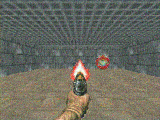

In [96]:
invTrans(x[49])

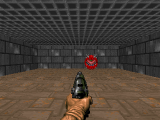

In [94]:
invTrans(target_frame[50])

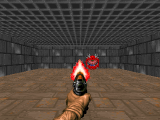

In [95]:
invTrans(prev_frame[50])

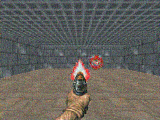

In [85]:
invTrans(x[50])